In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.sort_values(by="Date", inplace=True)
df.set_index('Date', inplace=True)


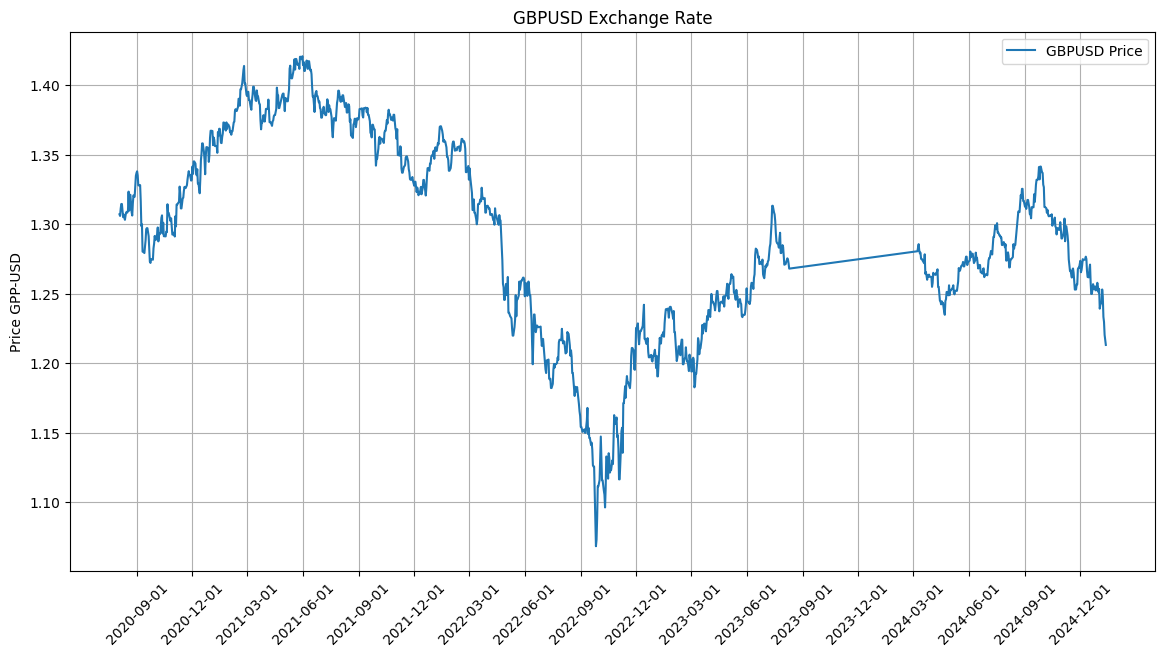

In [ ]:
from utils import split_train_validate_test


train_data, val_data, test_data = split_train_validate_test(df, 0.7, 0.15, 0.15)

print("Training Data Information:")
print("--------------------------")
print(f"Training Data: {train_data}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open']])

X_train_scaled = scaler.transform(train_data[['Open']])
X_val_scaled = scaler.transform(val_data[['Open']])
X_test_scaled = scaler.transform(test_data[['Open']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

Training Data: 935 samples
Validation Data: 132 samples
Test Data: 133 samples
Training Data Information:
--------------------------
Training Data: (935, 4)
Validation Data: (132, 4)
Test Data: (133, 4)


In [ ]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    print(X)
    print(y)
    for i in range(len(X) - time_interval): 
        X_range.append(X[i:i+time_interval]) ## contains scaled value
        y_range.append(y[i+time_interval]) ## contains actual value 
    return np.array(X_range), np.array(y_range)

time_interval= 60

X_train_seq, y_train_seq = time_sequence_generator(X_train_scaled, y_train, time_interval)
X_val_seq, y_val_seq = time_sequence_generator(X_val_scaled, y_val, time_interval)
X_test_seq, y_test_seq = time_sequence_generator(X_test_scaled, y_test, time_interval)

print(X_train_scaled, y_train_seq)


In [10]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    for i in range(len(X) - time_interval):
        X_range.append(X[i:i+time_interval])
        y_range.append(y[i+time_interval])
    return np.array(X_range), np.array(y_range)

In [11]:
time_interval= 60

X_train_seq, y_train_seq = time_sequence_generator(X_train_scaled, y_train, time_interval)
X_val_seq, y_val_seq = time_sequence_generator(X_val_scaled, y_val, time_interval)
X_test_seq, y_test_seq = time_sequence_generator(X_test_scaled, y_test, time_interval)

print(f"Shape of X_train: {X_train_seq.shape}")
print(f"Shape of X_val: {X_val_seq.shape}")
print(f"Shape of X_test: {X_test_seq.shape}")

Shape of X_train: (875, 60, 2)
Shape of X_val: (72, 60, 2)
Shape of X_test: (73, 60, 2)


In [ ]:
from kerastuner.tuners import Hyperband

# Build RNN model
def build_model(hp):
	model = Sequential()
	# Tune the number of RNN layers
	num_layers = hp.Int('num_layers', min_value=1, max_value=6)
	for i in range(num_layers):
		model.add(SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
			activation=hp.Choice('activation', values=['relu', 'tanh']),
			return_sequences=(i != num_layers - 1),
			input_shape=(time_interval, 2) if i == 0 else None
		))
		model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
	
	# Dense layers
	model.add(Dense(
		units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
		activation='relu'
	))
	model.add(Dense(units=1))  # Output layer

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mean_squared_error',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=50,
	factor=3,
	directory='hyperband_tuning',
	project_name='rnn_hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
rnn_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = rnn_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val_seq, y_val_seq))

In [ ]:
# Evaluate
test_loss = rnn_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (RNN): {test_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0281 - mae: 0.1665 - mse: 0.0281
Test Loss (RNN): [0.02483389712870121, 0.1558772772550583, 0.02483389712870121]


In [ ]:
# Predictions
y_pred = rnn_model.predict(X_test_seq)

y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_seq.reshape(-1, 1), np.zeros(y_test_seq.shape))))[:, 0]

mae_rnn = mean_absolute_error(y_test_actual, y_pred)
mse_rnn = mean_squared_error(y_test_actual, y_pred)
r2_rnn = r2_score(y_test_actual, y_pred)
mape_rnn = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [ ]:
print(f"RNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_rnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_rnn:.4f}")
print(f"R² Score: {r2_rnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rnn:.2f}%")

RNN Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0549
Mean Squared Error (MSE): 0.0031
R² Score: -27.1496
Mean Absolute Percentage Error (MAPE): 3.61%


In [ ]:

X_full_scaled = scaler.transform(df[['Open', 'Time']])
X_val_scaled = scaler.transform([['Open', 'Time']])
X_test_scaled = scaler.transform(test_data[['Open', 'Time']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

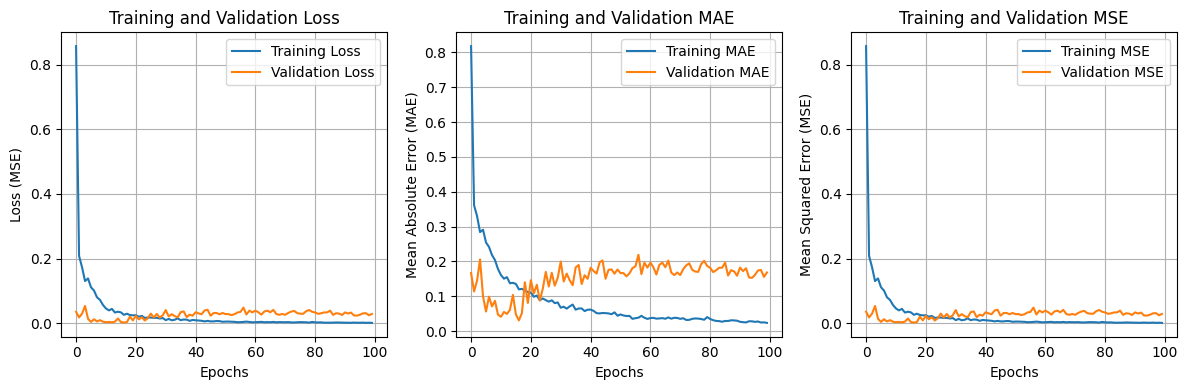

In [ ]:
# Plot Training History
history_dict = history.history

plt.figure(figsize=(12, 4))

# MAE
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()